<a href="https://colab.research.google.com/github/Yasser1930/machine-learning-SMS-spam-detection/blob/main/machine_learning_SMS_spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Détection de spam SMS**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Reshape, GRU, Dropout
from transformers import BertTokenizer, BertModel
from scipy.sparse import csr_matrix, hstack
from google.colab import drive
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from nltk.util import ngrams
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
import tensorflow as tf
from gensim.models import Word2Vec

nltk.download('wordnet')
nltk.download('punkt')
drive.mount('/content/drive')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Charger le fichier dans un DataFrame pandas
df = pd.read_csv("SMSSpamCollection.txt", sep="\t", header=None, names=["label", "message"])
print(df.head())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


# Exploratory analysis
1.   General informations
2.   Class distribution
3.   Word Cloud visualization
4. Add the columns : num_characters,	num_words to use them as features too




In [ ]:
# des informations sur les types de données et les valeurs manquantes
print("\nInformations sur les données :")
print(df.info())

# des statistiques descriptives sur les données
print("\nStatistiques descriptives :")
print(df.describe())


Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

Statistiques descriptives :
       label                 message
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30


We have 5572 entries (data point). There are only 2 labels in the dataset which are ham and spam. The message "*Sorry, I'll call you later*" was repeated 30 times. Ham presents 85.5% of total labels.


Distribution des classes :
ham     4825
spam     747
Name: label, dtype: int64


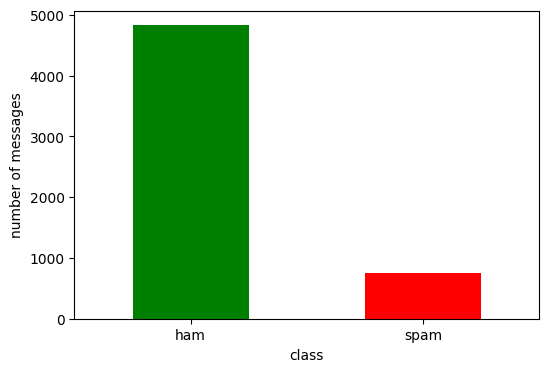

In [ ]:
# Afficher la distribution des classes (spam/ham)
print("\nDistribution des classes :")
print(df['label'].value_counts())

# la distribution des classes

plt.figure(figsize=(6, 4))
df['label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.xlabel('class')
plt.ylabel('number of messages')
plt.xticks(rotation=0)
plt.show()


*4825* line of entry were labeled *ham* and *747* labeled *spam*.




We eliminated the oversampling due to overfitting

In [ ]:
# # Filter the DataFrame to get only spam messages
# spam_df = df[df['label'] == 'spam']

# # Sample with replacement from the spam DataFrame to get additional spam messages
# oversampled_spam = spam_df.sample(n=4078, replace=True)

# # Concatenate the oversampled spam DataFrame with the original DataFrame
# df = pd.concat([df, oversampled_spam])

# # Shuffle the DataFrame to randomize the order of messages
# df = df.sample(frac=1).reset_index(drop=True)


Distribution des classes :
ham     4825
spam     747
Name: label, dtype: int64


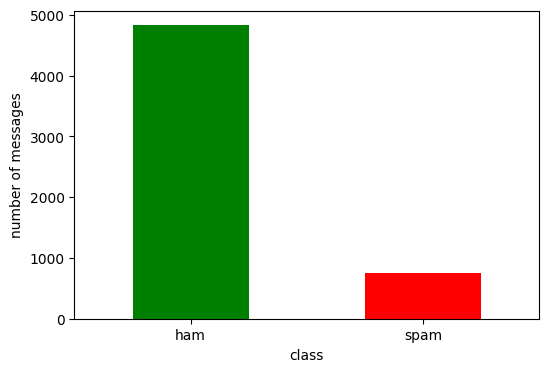

In [ ]:
# Afficher la distribution des classes (spam/ham)
print("\nDistribution des classes :")
print(df['label'].value_counts())

# la distribution des classes
plt.figure(figsize=(6, 4))
df['label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.xlabel('class')
plt.ylabel('number of messages')
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Separate messages by labels
ham_messages = df[df['label'] == 'ham']['message']
spam_messages = df[df['label'] == 'spam']['message']


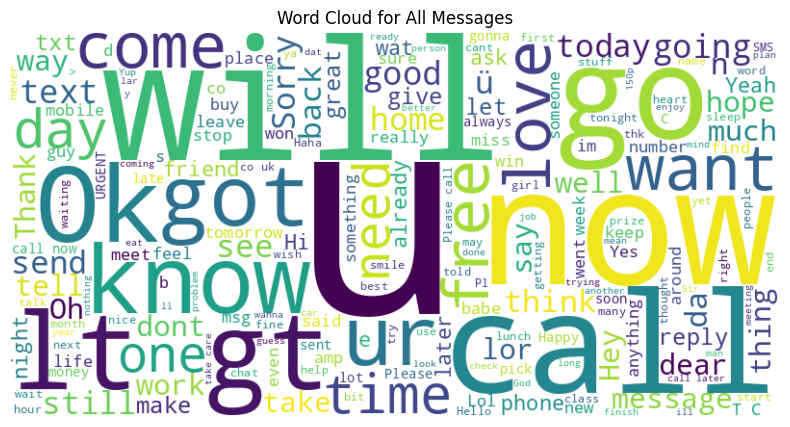

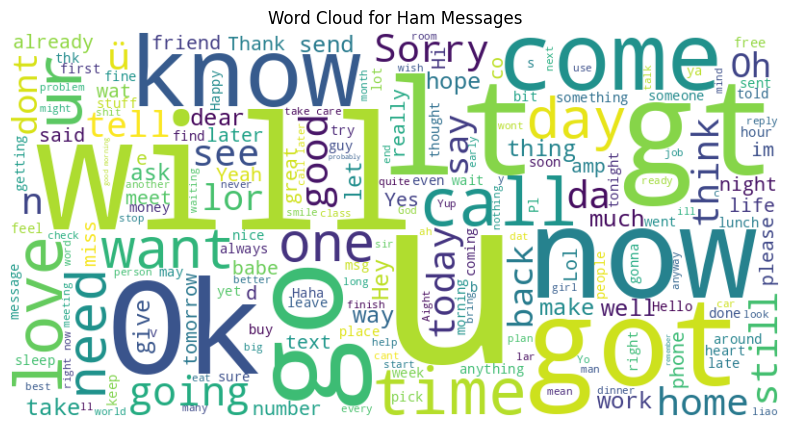

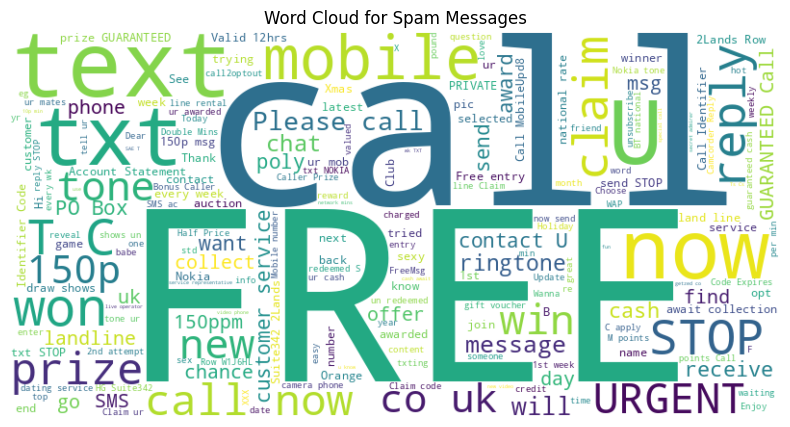

In [ ]:
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word cloud for All messages
all_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['message']))
plt.figure(figsize=(10, 5))
plt.imshow(all_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for All Messages')
plt.axis('off')
plt.show()

# Generate word cloud for 'ham' messages
# Separate messages by labels first
ham_messages = df[df['label'] == 'ham']['message']
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(ham_messages))
plt.figure(figsize=(10, 5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages')
plt.axis('off')
plt.show()

# Generate word cloud for 'spam' messages
spam_messages = df[df['label'] == 'spam']['message']
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_messages))
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')
plt.show()



We can see that the most used words through the word cloud which is a visualization technique used to represent the frequency of words in a given text, and in our case the messages.

In [ ]:
df['num_words'] = df['message'].apply(lambda x : len(nltk.word_tokenize(x)))
df.head()


,label,message,num_words
0,ham,"Go until jurong point, crazy.. Available only ...",24
1,ham,Ok lar... Joking wif u oni...,8
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,37
3,ham,U dun say so early hor... U c already then say...,13
4,ham,"Nah I don't think he goes to usf, he lives aro...",15


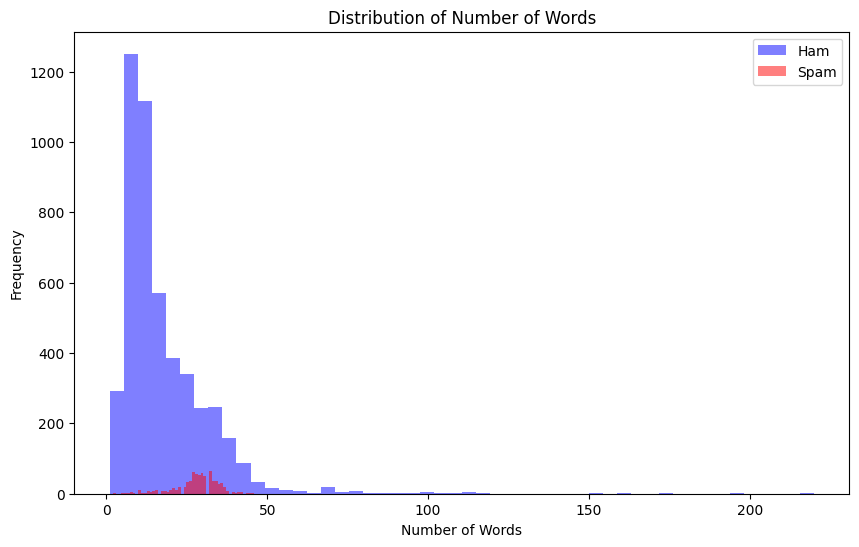

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df[df['label'] == 'ham']['num_words'], bins=50, color='blue', alpha=0.5, label='Ham')
plt.hist(df[df['label'] == 'spam']['num_words'], bins=50, color='red', alpha=0.5, label='Spam')
plt.title('Distribution of Number of Words')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
df.describe()


,num_words
count,5572.000000
mean,18.842426
std,13.851947
min,1.000000
25%,9.000000
50%,15.000000
75%,27.000000
max,220.000000


In [ ]:
df[df['label'] == 'ham'].describe()


NameError: name 'df' is not defined

In [ ]:
df[df['label'] == 'spam'].describe()


,num_words
count,747.000000
mean,27.993307
std,6.860440
min,2.000000
25%,25.000000
50%,29.000000
75%,32.000000
max,46.000000


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def scale_num_words(df):
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler on the 'num_words' column and transform it
    df['num_words'] = scaler.fit_transform(df[['num_words']])

    return df
df = scale_num_words(df)
print(df.head())


  label                                            message  num_words
0   ham  Go until jurong point, crazy.. Available only ...   0.105023
1   ham                      Ok lar... Joking wif u oni...   0.031963
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...   0.164384
3   ham  U dun say so early hor... U c already then say...   0.054795
4   ham  Nah I don't think he goes to usf, he lives aro...   0.063927


# Preprocessing
1.   Data cleaning by removing repeating letters, numbers and punctuation
2. Tokenization by putting words or symbols ofeach message in an array
3.   Word Cloud visualization after cleaning
4. See uni, bi and tri grams
5. Did some feature engineering by extracting 10 keywords for the spam messages


In [ ]:

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

ps = PorterStemmer()

def clean_text(text):
    # Lowercase the text first to ensure consistency
    text = text.lower()
    # Replace email addresses with a special token
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w{2,4}\b', '__email__', text)
    # Replace URLs with a special token
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '__url__', text)
    # Mark numbers with a special token (while keeping them)
    text = re.sub(r'\b\d+\b', '__number__', text)
    # Remove all non-letters, non-special tokens, allowing spaces and slashes for tokenization
    # Adjusted regex to keep slashes
    text = re.sub(r'(?<!__)[^a-zA-Z\s/]', ' ', text)  # Negative lookbehind to keep our tokens, now allowing slashes
    # Tokenize using NLTK
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    # Apply stemming
    tokens = [ps.stem(token) for token in tokens]
    # Rejoin the tokens into a string
    return ' '.join(tokens)

# Applying the refined function to your DataFrame
df['cleaned_message'] = df['message'].apply(clean_text)

# Display the DataFrame to verify the results
print(df[['message', 'cleaned_message']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                     cleaned_message  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri number wkli comp win fa cup final t...  
3                u dun say earli hor u c alreadi say  
4               nah think goe usf live around though  


In [ ]:
clean_text("I it  you loved the TP lectureees . on Machine LEArning. How about you ???")

'love tp lecturee machin learn'

In [ ]:
df

,label,message,num_words,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",0.105023,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,0.031963,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0.164384,free entri number wkli comp win fa cup final t...
3,ham,U dun say so early hor... U c already then say...,0.054795,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0.063927,nah think goe usf live around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,0.155251,nd time tri number contact u u number pound pr...
5568,ham,Will ü b going to esplanade fr home?,0.036530,b go esplanad fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",0.063927,piti mood suggest
5570,ham,The guy did some bitching but I acted like i'd...,0.118721,guy bitch act like interest buy someth els nex...


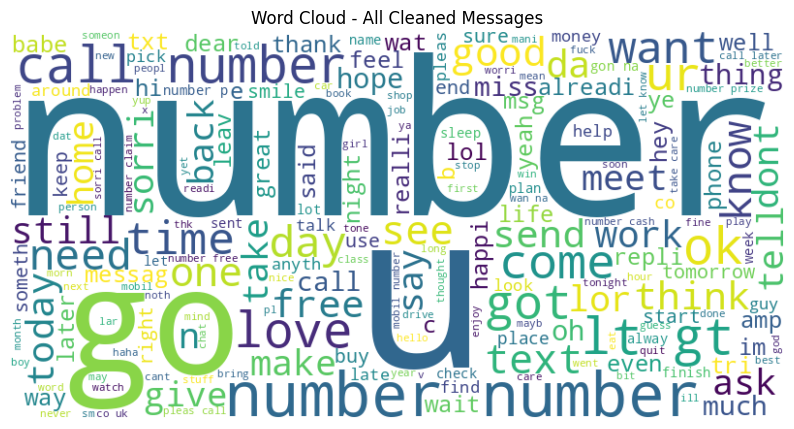

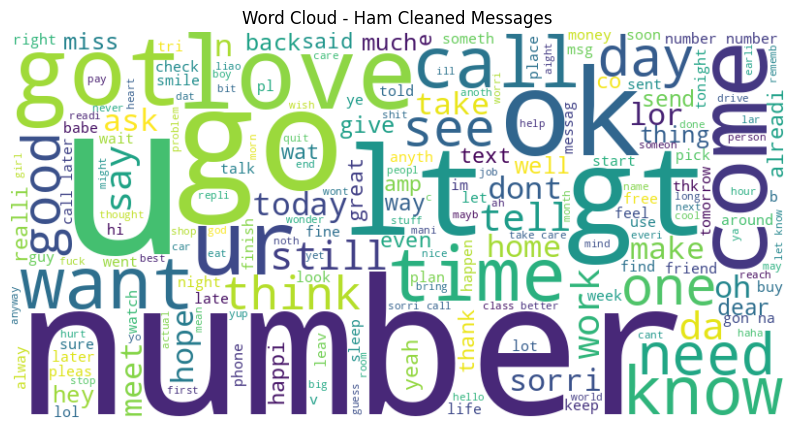

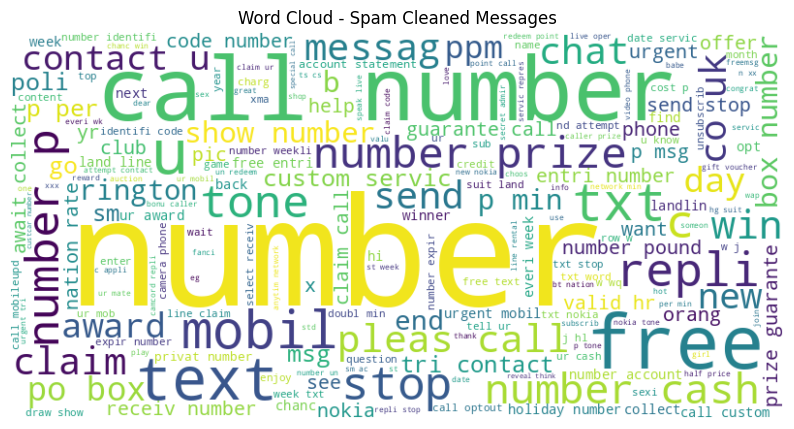

In [ ]:
# Generate word cloud for the entire DataFrame using cleaned messages
all_cleaned_text = ' '.join(df['cleaned_message'])
generate_word_cloud(all_cleaned_text, title='Word Cloud - All Cleaned Messages')

# Generate word cloud for 'ham' labeled messages using cleaned messages
ham_cleaned_text = ' '.join(df[df['label'] == 'ham']['cleaned_message'])
generate_word_cloud(ham_cleaned_text, title='Word Cloud - Ham Cleaned Messages')

# Generate word cloud for 'spam' labeled messages using cleaned messages
spam_cleaned_text = ' '.join(df[df['label'] == 'spam']['cleaned_message'])
generate_word_cloud(spam_cleaned_text, title='Word Cloud - Spam Cleaned Messages')


In [ ]:
df['tokens'] = df['cleaned_message'].apply(word_tokenize)

# Flatten the list of lists into a single list of tokens
all_tokens = [token for sublist in df['tokens'] for token in sublist]

# Generate and count n-grams
unigrams = Counter(ngrams(all_tokens, 1))
bigrams = Counter(ngrams(all_tokens, 2))
trigrams = Counter(ngrams(all_tokens, 3))

# Example output
print(unigrams.most_common(10))
print(bigrams.most_common(10))
print(trigrams.most_common(10))


[(('number',), 3187), (('u',), 1213), (('call',), 695), (('go',), 462), (('get',), 458), (('ur',), 391), (('.',), 357), (('gt',), 318), (('lt',), 316), (('come',), 305)]
[(('number', '.'), 357), (('lt', 'gt'), 276), (('call', 'number'), 265), (('number', 'number'), 153), (('.', 'number'), 108), (('number', ','), 87), (('/', 'number'), 67), (('number', '/'), 66), (('number', '+'), 59), (('gon', 'na'), 58)]
[(('number', '.', 'number'), 108), (('number', '/', 'number'), 64), (('number', ',', 'number'), 40), (('sorri', 'call', 'later'), 38), (('number', 'number', 'number'), 36), (('call', 'number', '.'), 30), (('pleas', 'call', 'number'), 29), (('number', 'cash', 'number'), 25), (('po', 'box', 'number'), 25), (('/', 'number', '/'), 25)]


In [ ]:

def generate_ngrams(tokens_list, n):
    # Flatten the list of tokens if it's a list of lists
    flattened_tokens = [token for sublist in tokens_list for token in sublist]
    # Generate n-grams
    ngrams_list = list(ngrams(flattened_tokens, n))
    # Count the frequency of each n-gram
    ngram_freq = Counter(ngrams_list)
    return ngram_freq

def top_ngrams_by_label(df, label_column, text_column, n=10):
    # Group the DataFrame by the label column
    grouped = df.groupby(label_column)
    # Iterate over each group
    for label, group in grouped:
        print(f"\nTop {n} N-grams for label: {label}")
        # The tokens are already in a list, so no need for further flattening
        for n_size in range(1, 4): # For unigrams, bigrams, trigrams
            ngram_freq = generate_ngrams(group[text_column], n_size)
            print(f"\nTop {n} {['Unigrams', 'Bigrams', 'Trigrams'][n_size-1]}:")
            for ngram, frequency in ngram_freq.most_common(n):
                # Format n-gram tuple to a readable string
                ngram_str = ' '.join(ngram)
                print(f"{ngram_str} - {frequency}")

top_ngrams_by_label(df, 'label', 'tokens', n=10)



Top 10 N-grams for label: ham

Top 10 Unigrams:
u - 1033
number - 1006
go - 425
get - 368
gt - 318
lt - 316
call - 300
come - 300
ok - 288
love - 256

Top 10 Bigrams:
lt gt - 276
number . - 107
gon na - 58
call later - 52
let know - 41
take care - 40
sorri call - 38
r u - 38
u r - 35
go number - 33

Top 10 Trigrams:
sorri call later - 38
lt decim gt - 23
number . number - 21
u wan number - 21
lt gt min - 19
happi new year - 19
like lt gt - 14
pl send messag - 13
cant pick phone - 12
pick phone right - 12

Top 10 N-grams for label: spam

Top 10 Unigrams:
number - 2181
call - 395
. - 250
free - 228
u - 180
txt - 175
ur - 144
text - 142
mobil - 142
stop - 125

Top 10 Bigrams:
call number - 258
number . - 250
number number - 134
. number - 91
number / - 66
/ number - 65
number , - 63
number prize - 56
number cash - 54
number + - 48

Top 10 Trigrams:
number . number - 91
number / number - 64
number , number - 34
call number . - 29
pleas call number - 29
number number number - 27
number cas

# Feature Engineering (eliminated due to overfitting)
1. Extracted 10 keywords for the spam messages.
2. Added binary indicators for the presence of these keywords in each message as additional features in the dataset.

In [ ]:
# # Separate spam and ham messages
# spam_tokens = df[df['label'] == 'spam']['tokens']
# ham_tokens = df[df['label'] == 'ham']['tokens']

# # Flatten the list of spam and ham tokens
# spam_words = [word for sublist in spam_tokens for word in sublist]
# ham_words = [word for sublist in ham_tokens for word in sublist]

# # Calculate word frequencies
# spam_word_freq = Counter(spam_words)
# ham_word_freq = Counter(ham_words)

# # Identify keywords used in spam but not in ham
# keywords = []
# for word, freq in spam_word_freq.items():
#     if word not in ham_word_freq or spam_word_freq[word] > ham_word_freq[word]:
#         keywords.append(word)

# # Select top 10 keywords
# keywords = sorted(keywords, key=lambda x: spam_word_freq[x], reverse=True)[:10]

# print("Top 10 keywords used in spam messages:", keywords)


In [ ]:
# # Function to check the presence of keywords in each message
# def check_keyword_presence(tokens):
#     presence = []
#     for keyword in keywords:
#         if keyword in tokens:
#             presence.append(1)
#         else:
#             presence.append(0)
#     return presence

# # add binary indicators for the presence of keywords in each message
# for keyword in keywords:
#     df[keyword + '_presence'] = df['tokens'].apply(lambda x: 1 if keyword in x else 0)

# print(df.columns)


In [ ]:
# # Initialize dictionaries to store keyword presence counts for ham and spam messages
# ham_keyword_counts = {keyword: 0 for keyword in keywords}
# spam_keyword_counts = {keyword: 0 for keyword in keywords}

# # Count the presence of keywords in ham messages
# for tokens in ham_tokens:
#     for keyword in keywords:
#         if keyword in tokens:
#             ham_keyword_counts[keyword] += 1

# # Count the presence of keywords in spam messages
# for tokens in spam_tokens:
#     for keyword in keywords:
#         if keyword in tokens:
#             spam_keyword_counts[keyword] += 1

# # Convert the dictionaries to DataFrame for better visualization
# keyword_presence_counts = pd.DataFrame({'Ham': ham_keyword_counts, 'Spam': spam_keyword_counts})

# # Display the keyword presence counts for ham and spam
# print("Keyword presence counts for ham and spam:")
# print(keyword_presence_counts)


# **Word embedding**

1.   Word2Vec
2.   GloVe
3. TF-IDF


In [ ]:
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

df.drop(columns=['message'], inplace=True)

In [ ]:
df.head(5)

,label,num_words,cleaned_message,tokens
0,0,0.105023,go jurong point crazi avail bugi n great world...,"[go, jurong, point, crazi, avail, bugi, n, gre..."
1,0,0.031963,ok lar joke wif u oni,"[ok, lar, joke, wif, u, oni]"
2,1,0.164384,free entri number wkli comp win fa cup final t...,"[free, entri, number, wkli, comp, win, fa, cup..."
3,0,0.054795,u dun say earli hor u c alreadi say,"[u, dun, say, earli, hor, u, c, alreadi, say]"
4,0,0.063927,nah think goe usf live around though,"[nah, think, goe, usf, live, around, though]"


In [ ]:
!pip install gensim

Word2Vec

In [ ]:

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, sg=1)

def get_vectorized_tokens(tokens):
    return np.array([word2vec_model.wv[token] if token in word2vec_model.wv else np.zeros(100) for token in tokens])

df['word2vec_embeddings'] = df['tokens'].apply(get_vectorized_tokens)

def average_embeddings(embeddings):
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(100)

df['avg_word2vec'] = df['word2vec_embeddings'].apply(average_embeddings)


num_words_array = df['num_words'].values.reshape(-1, 1)

avg_word2vec_array = np.stack(df['avg_word2vec'].values)

combined_features_word2vec = np.hstack((avg_word2vec_array, num_words_array))

similar_words = word2vec_model.wv.most_similar('free')
print(similar_words)


GloVe

In [ ]:

def load_glove_model(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index
glove_file_path = '/content/drive/My Drive/Project/glove.42B.300d.txt'

glove_model = load_glove_model(glove_file_path)

def get_average_glove_embedding(tokens, embeddings_index, vector_size=300):
    # Retrieve embeddings for each token and take the mean
    embeddings = np.array([embeddings_index.get(token, np.zeros(vector_size)) for token in tokens])
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

df['avg_glove'] = df['tokens'].apply(lambda tokens: get_average_glove_embedding(tokens, glove_model, 300))

# Prepare the combined GloVe and num_words features
avg_glove_array = np.stack(df['avg_glove'].values)

num_words_array = df['num_words'].values.reshape(-1, 1)

combined_avg_features_glove = np.hstack((avg_glove_array, num_words_array))



In [ ]:
df.head()

,label,num_words,cleaned_message,tokens
0,0,0.105023,go jurong point crazi avail bugi n great world...,"[go, jurong, point, crazi, avail, bugi, n, gre..."
1,0,0.031963,ok lar joke wif u oni,"[ok, lar, joke, wif, u, oni]"
2,1,0.164384,free entri number wkli comp win fa cup final t...,"[free, entri, number, wkli, comp, win, fa, cup..."
3,0,0.054795,u dun say earli hor u c alreadi say,"[u, dun, say, earli, hor, u, c, alreadi, say]"
4,0,0.063927,nah think goe usf live around though,"[nah, think, goe, usf, live, around, though]"


TF-IDF

In [ ]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_message'])

num_words_sparse = csr_matrix(df['num_words'].values.reshape(-1, 1))

# Horizontally stack the TF-IDF sparse matrix with the scaled num_words sparse matrix
tfidf = hstack([tfidf_matrix, num_words_sparse])

BERT

In [ ]:

# # Initialize the tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

# # Ensure you've defined your DataFrame 'df' with 'cleaned_message' and scaled 'num_words' ready
# def get_bert_embedding_with_num_words(text, num_words_scaled):
#     inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
#     input_ids = inputs['input_ids']
#     attention_mask = inputs['attention_mask']

#     with torch.no_grad():
#         outputs = model(input_ids, attention_mask=attention_mask)

#     embeddings = outputs.pooler_output.cpu().numpy()
#     combined_features = np.concatenate((embeddings, np.array([[num_words_scaled]])), axis=1)

#     return combined_features.squeeze()

# # For applying to the entire DataFrame (caution: computationally intensive)
# df['bert_with_num_words'] = df.apply(lambda row: get_bert_embedding_with_num_words(row['cleaned_message'], row['num_words']), axis=1)


# **Models**

## **Using combined_features_word2vec**

- Decision Tree
- Logistic Regression
- KNN
- Naive Bayes
- SVM
- Random Forest


In [ ]:
X_train_word2vec, X_test_word2vec, y_train, y_test = train_test_split(
    combined_features_word2vec,
    df['label'].values,
    test_size=0.2,
    random_state=42  # Ensures reproducibility
)

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier()
}

results = {}

# Train, predict, and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_word2vec, y_train)
    predictions = model.predict(X_test_word2vec)

    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)

    results[name] = {"Accuracy": accuracy, "Report": report, "Confusion Matrix": conf_matrix}

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Display results
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {metrics['Accuracy']}")
    print("Classification Report:")
    print(metrics["Report"])
    print("======================================\n")


**LSTM**

In [ ]:
# Define the LSTM model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_word2vec.shape[1],)),  # Input layer shape based on features
    tf.keras.layers.Reshape((X_train_word2vec.shape[1], 1)),  # Reshape for LSTM if needed, assuming 1D features per time step
    tf.keras.layers.LSTM(64),  # LSTM layer with 64 units
    tf.keras.layers.Dense(64, activation='relu'),  # Dense layer for further processing
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model with binary crossentropy loss and the Adam optimizer
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model on the training data
history = model.fit(X_train_word2vec, y_train, epochs=10, validation_split=0.2)
# Generate predictions for the test set
predictions = model.predict(X_test_word2vec)
predictions = (predictions > 0.5).astype(int).flatten()

# Display accuracy and classification report
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(classification_report(y_test, predictions))

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de Perte du Modèle LSTM')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.show()


**BiLSTM**

In [ ]:


# Define the BiLSTM model
model = Sequential([
    # Input layer explicitly might not be needed; the first LSTM layer will infer input shape from the data
    Bidirectional(LSTM(units=64, return_sequences=True, input_shape=(X_train_word2vec.shape[1], 1))),
    Bidirectional(LSTM(units=32)),  # Second BiLSTM layer for deeper learning; adjust units as needed
    Dense(units=64, activation='relu'),  # Dense layer for learning non-linear combinations
    Dense(units=1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use 'binary_crossentropy' for binary classification
              metrics=['accuracy'])

X_train_reshaped = X_train_word2vec.reshape((X_train_word2vec.shape[0], X_train_word2vec.shape[1], 1))
X_test_reshaped = X_test_word2vec.reshape((X_test_word2vec.shape[0], X_test_word2vec.shape[1], 1))

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=5, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test accuracy: {test_accuracy}")
# Generate predictions
predictions = model.predict(X_test_reshaped)
# Convert probabilities to class labels [Assuming 0.5 as the threshold]
predictions_labels = (predictions > 0.5).astype(int).flatten()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, predictions_labels))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de Perte du Modèle BiLSTM')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.show()


**GRU**




In [ ]:


# Define the GRU model architecture
model_gru = Sequential([
    GRU(units=64, return_sequences=True, input_shape=(X_train_word2vec.shape[1], 1)),  # First GRU layer
    Dropout(0.2),  # Dropout
    GRU(units=32),  # Second GRU layer
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model_gru.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history_gru = model_gru.fit(X_train_word2vec, y_train, epochs=5, validation_split=0.2)

test_loss_gru, test_accuracy_gru = model_gru.evaluate(X_test_word2vec, y_test)
print(f"Test accuracy with GRU: {test_accuracy_gru}")

predictions_gru = (model_gru.predict(X_test_word2vec) > 0.5).astype(int).flatten()


print(classification_report(y_test, predictions_gru, target_names=['Class 0', 'Class 1']))
conf_matrix_gru = confusion_matrix(y_test, predictions_gru)

# conf_matrix_gru
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gru, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for GRU Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Courbe de Perte du Modèle GRU')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.show()

**CNN**

In [ ]:

# Define the CNN model
model_cnn = Sequential([
    Reshape((X_train_word2vec.shape[1], 1), input_shape=(X_train_word2vec.shape[1],)),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=4),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model_cnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
history_cnn = model_cnn.fit(X_train_word2vec, y_train, epochs=5, validation_split=0.2)

# Evaluate the model on the test set
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test_word2vec, y_test)
print(f"Test accuracy: {test_accuracy_cnn}")

# Generate predictions and compute the confusion matrix
predictions_cnn = (model_cnn.predict(X_test_word2vec) > 0.5).astype("int32").flatten()
conf_matrix_cnn = confusion_matrix(y_test, predictions_cnn)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN Confusion Matrix')
plt.show()

# Calculate and print the classification report
print("CNN Model Performance:")
print(classification_report(y_test, predictions_cnn, target_names=['Class 0', 'Class 1']))
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Courbe de Perte du Modèle CNN')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.show()

## Using **combined_avg_features_glove**

- Decision Tree
- Logistic Regression
- KNN
- Naive Bayes
- SVM
- Random Forest


In [ ]:
X_train_glove, X_test_glove, y_train, y_test = train_test_split(
    combined_avg_features_glove,
    df['label'].values,
    test_size=0.2,
    random_state=42
)
combined_avg_features_glove
# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier()
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_glove, y_train)
    predictions = model.predict(X_test_glove)

    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)

    results[name] = {"Accuracy": accuracy, "Report": report, "Confusion Matrix": conf_matrix}

    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {metrics['Accuracy']}")
    print("Classification Report:")
    print(metrics["Report"])
    print("======================================\n")


**LSTM**

In [ ]:


# Define the LSTM model architecture for combined_avg_features_glove
model_lstm_glove = Sequential([
    tf.keras.layers.Input(shape=(X_train_glove.shape[1],)),
    tf.keras.layers.Reshape((X_train_glove.shape[1], 1)),
    # LSTM layer
    tf.keras.layers.LSTM(64),
    # Dense layers for further processing
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm_glove.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm_glove = model_lstm_glove.fit(X_train_glove, y_train, epochs=10, validation_split=0.2)

predictions_lstm_glove = (model_lstm_glove.predict(X_test_glove) > 0.5).astype(int).flatten()

accuracy_lstm_glove = accuracy_score(y_test, predictions_lstm_glove)
print(f"Accuracy: {accuracy_lstm_glove}")
print(classification_report(y_test, predictions_lstm_glove))
conf_matrix_lstm_glove = confusion_matrix(y_test, predictions_lstm_glove)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lstm_glove, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LSTM with GloVe Confusion Matrix')
plt.show()


**BiLSTM**

In [ ]:
from tensorflow.keras.layers import Input

# Define the BiLSTM model architecture
model_bi_lstm_glove = Sequential([
    Input(shape=(X_train_glove.shape[1], 1)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_bi_lstm_glove.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
X_train_glove_reshaped = X_train_glove.reshape((X_train_glove.shape[0], X_train_glove.shape[1], 1))
X_test_glove_reshaped = X_test_glove.reshape((X_test_glove.shape[0], X_test_glove.shape[1], 1))

history_bi_lstm_glove = model_bi_lstm_glove.fit(X_train_glove_reshaped, y_train, epochs=10, validation_split=0.2)

predictions_bi_lstm_glove = model_bi_lstm_glove.predict(X_test_glove_reshaped)
predictions_bi_lstm_glove = (predictions_bi_lstm_glove > 0.5).astype(int).flatten()
print("BiLSTM Model Performance with GloVe Features:")
print(classification_report(y_test, predictions_bi_lstm_glove))
print(f"Accuracy: {accuracy_score(y_test, predictions_bi_lstm_glove)}")

conf_matrix_bi_lstm_glove = confusion_matrix(y_test, predictions_bi_lstm_glove)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_bi_lstm_glove, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('BiLSTM with GloVe Confusion Matrix')
plt.show()


**GRU**

In [ ]:

model_gru = Sequential([
    GRU(units=64, return_sequences=True, input_shape=(X_train_glove.shape[1], 1)),
    Dropout(0.2),
    GRU(units=32),
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model_gru.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
X_train_glove_reshaped = X_train_glove.reshape((X_train_glove.shape[0], X_train_glove.shape[1], 1))
X_test_glove_reshaped = X_test_glove.reshape((X_test_glove.shape[0], X_test_glove.shape[1], 1))
history_gru = model_gru.fit(X_train_glove_reshaped, y_train, epochs=5, validation_split=0.2)

test_loss_gru, test_accuracy_gru = model_gru.evaluate(X_test_glove_reshaped, y_test)
print(f"Test accuracy with GRU: {test_accuracy_gru}")

predictions_gru = (model_gru.predict(X_test_glove_reshaped) > 0.5).astype(int).flatten()

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print(classification_report(y_test, predictions_gru, target_names=['Class 0', 'Class 1']))
conf_matrix_gru = confusion_matrix(y_test, predictions_gru)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gru, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for GRU Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


We had a problem due to the imbalance of the data so we will try to improve: Class Weighting: Apply class weights during training to address the imbalance.
Model Architecture Tweaks: Add additional dropout for regularization and consider experimenting with the number of units in the GRU layers.
Optimizer and Learning Rate Adjustment: Sometimes, adjusting the optimizer's learning rate can help the model converge better.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np


class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights_dict = dict(enumerate(class_weights))


model_gru = Sequential([
    GRU(units=64, return_sequences=True, input_shape=(X_train_glove.shape[1], 1)),
    Dropout(0.3),
    GRU(units=64),
    Dropout(0.3),
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model with the adjusted optimizer
model_gru.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

X_train_glove_reshaped = X_train_glove.reshape((X_train_glove.shape[0], X_train_glove.shape[1], 1))
X_test_glove_reshaped = X_test_glove.reshape((X_test_glove.shape[0], X_test_glove.shape[1], 1))

history_gru = model_gru.fit(X_train_glove_reshaped, y_train, epochs=5, validation_split=0.2, class_weight=class_weights_dict)

# Evaluate the model's performance
test_loss_gru, test_accuracy_gru = model_gru.evaluate(X_test_glove_reshaped, y_test)
print(f"Test accuracy with GRU: {test_accuracy_gru}")

# Generate and evaluate predictions
predictions_gru = (model_gru.predict(X_test_glove_reshaped) > 0.5).astype(int).flatten()
print(classification_report(y_test, predictions_gru, target_names=['Class 0', 'Class 1']))

# Display the confusion matrix
conf_matrix_gru = confusion_matrix(y_test, predictions_gru)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gru, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for GRU Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


**CNN**

In [ ]:

# Define the CNN model architecture adapted for GloVe features
model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_glove.shape[1], 1)),
    Dropout(0.5),  # Increased dropout for regularization
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(units=64, activation='relu'),
    Dropout(0.5),  # Additional dropout layer before the final layer
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model_cnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Reshape GloVe features for the CNN model
X_train_glove_reshaped = X_train_glove.reshape((X_train_glove.shape[0], X_train_glove.shape[1], 1))
X_test_glove_reshaped = X_test_glove.reshape((X_test_glove.shape[0], X_test_glove.shape[1], 1))
# Train the model with the training data
history_cnn = model_cnn.fit(X_train_glove_reshaped, y_train, epochs=10, validation_split=0.2)

# Evaluate the model performance on the test set
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test_glove_reshaped, y_test)
print(f"Test accuracy with CNN: {test_accuracy_cnn}")


# Generate predictions with the CNN model
predictions_cnn = (model_cnn.predict(X_test_glove_reshaped) > 0.5).astype(int).flatten()

# Display the classification report
print("CNN Model Performance on GloVe Features:")
print(classification_report(y_test, predictions_cnn, target_names=['Class 0', 'Class 1']))

# Calculate and plot the confusion matrix
conf_matrix_cnn = confusion_matrix(y_test, predictions_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for CNN Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Using **TF-IDF**

Decision Tree
Logistic Regression
KNN
Naive Bayes
SVM
Random Forest

Training Decision Tree...


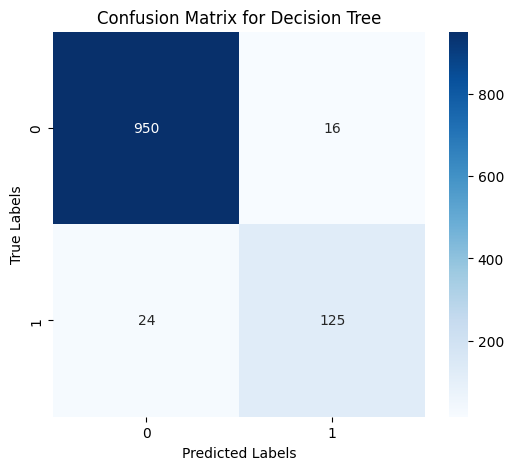

Training Logistic Regression...


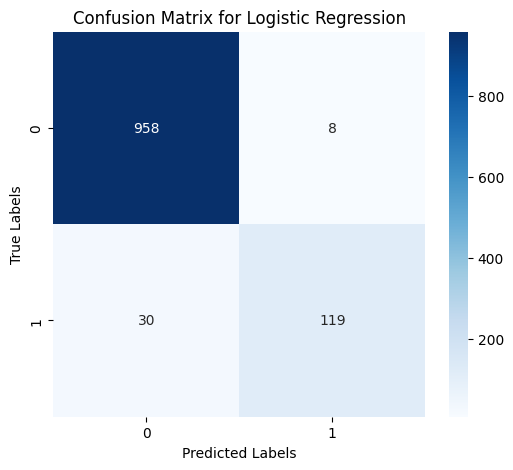

Training KNN...


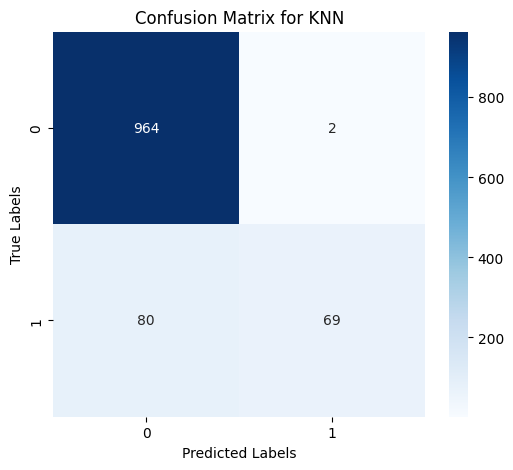

Training Naive Bayes...


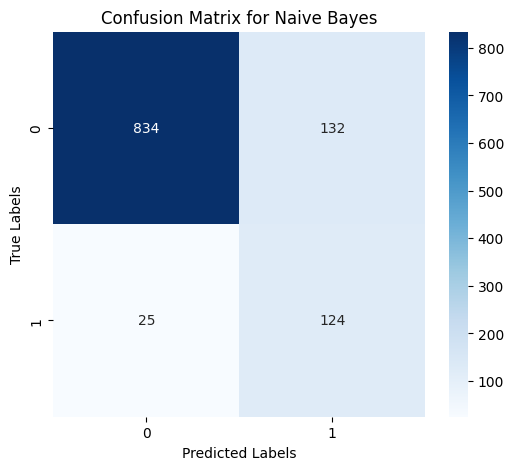

Training SVM...


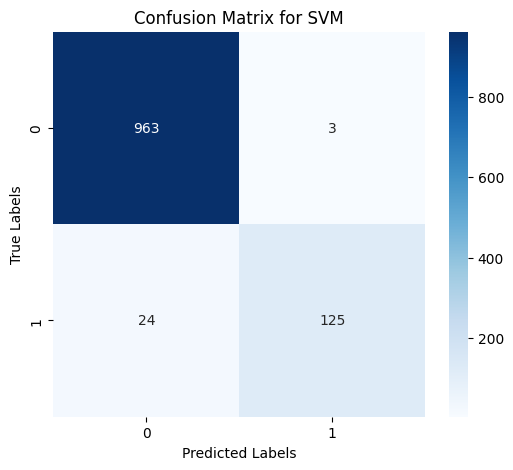

Training Random Forest...


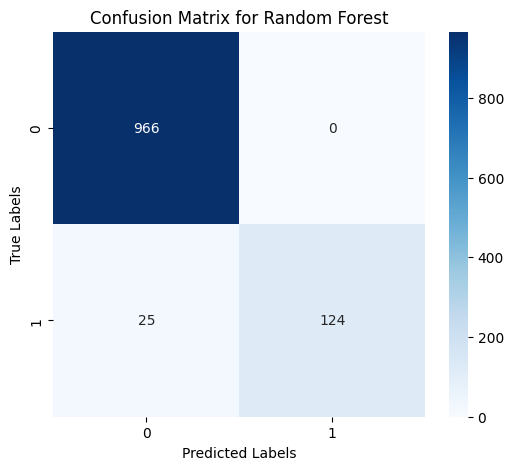

Model: Decision Tree
Accuracy: 0.9641255605381166
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       966
           1       0.89      0.84      0.86       149

    accuracy                           0.96      1115
   macro avg       0.93      0.91      0.92      1115
weighted avg       0.96      0.96      0.96      1115


Model: Logistic Regression
Accuracy: 0.9659192825112107
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       966
           1       0.94      0.80      0.86       149

    accuracy                           0.97      1115
   macro avg       0.95      0.90      0.92      1115
weighted avg       0.97      0.97      0.96      1115


Model: KNN
Accuracy: 0.9264573991031391
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       966
           1       0

In [ ]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    tfidf,
    df['label'].values,  # Assurez-vous que df['label'] contient les étiquettes de vos données
    test_size=0.2,
    random_state=42
)

# Définition des modèles à évaluer
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier()
}

# Initialisation du dictionnaire pour stocker les résultats
results = {}

# Entraînement, prédiction et évaluation de chaque modèle
for name, model in models.items():
    print(f"Training {name}...")
    if name == "Naive Bayes":  # Le modèle Naive Bayes nécessite une conversion en array dense
        model.fit(X_train_tfidf.toarray(), y_train)
        predictions = model.predict(X_test_tfidf.toarray())
    else:
        model.fit(X_train_tfidf, y_train)
        predictions = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)

    results[name] = {"Accuracy": accuracy, "Report": report, "Confusion Matrix": conf_matrix}

    # Affichage de la matrice de confusion
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Affichage des résultats pour chaque modèle
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {metrics['Accuracy']}")
    print("Classification Report:")
    print(metrics["Report"])
    print("======================================\n")


***LSTM***

In [ ]:
# Reshaping the data for LSTM
X_train_lstm = X_train_tfidf.toarray().reshape((X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1))
X_test_lstm = X_test_tfidf.toarray().reshape((X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1))
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_lstm = Sequential([
    LSTM(units=64, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_lstm = model_lstm.fit(X_train_lstm, y_train, epochs=5, validation_split=0.2)
test_loss, test_accuracy = model_lstm.evaluate(X_test_lstm, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions and evaluate
predictions_lstm = (model_lstm.predict(X_test_lstm) > 0.5).astype(int).flatten()
print(classification_report(y_test, predictions_lstm))

conf_matrix_lstm = confusion_matrix(y_test, predictions_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LSTM Confusion Matrix')
plt.show()


This setup allows us to train an LSTM model using TF-IDF features, but it's important to remember that LSTMs are primarily designed for sequence data where the order of data points is significant. The adaptation here treats each document as a sequence of individual features, which might not fully leverage the LSTM's capabilities for capturing temporal or sequential patterns. For text classification tasks, other models like CNNs or simple dense networks might perform equally well or better without the need to reshape the data into a 3D structure.

In [ ]:
import matplotlib.pyplot as plt

# Tracer la courbe de perte
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Courbe de Perte du LSTM')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de Précision du LSTM')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()


**BiLSTM**

In [ ]:
from tensorflow.keras.layers import Bidirectional

# Création du modèle BiLSTM
model_bilstm = Sequential([
    Bidirectional(LSTM(units=64, return_sequences=False), input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model_bilstm.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Entraînement du modèle
history_bilstm = model_bilstm.fit(X_train_lstm, y_train, epochs=5, validation_split=0.2)
test_loss_bilstm, test_accuracy_bilstm = model_bilstm.evaluate(X_test_lstm, y_test)
print(f"Test Accuracy with BiLSTM: {test_accuracy_bilstm}")

predictions_bilstm = (model_bilstm.predict(X_test_lstm) > 0.5).astype(int).flatten()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predictions_bilstm))

conf_matrix_bilstm = confusion_matrix(y_test, predictions_bilstm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_bilstm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - BiLSTM')
plt.show()



On va ajuster le modele par ajouter des weights

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional
import matplotlib.pyplot as plt

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_message'])
sequences = tokenizer.texts_to_sequences(df['cleaned_message'])
max_length = max(len(sequence) for sequence in sequences)
X = pad_sequences(sequences, maxlen=max_length)
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_length))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, validation_split=0.2, class_weight=class_weight_dict)

# Évaluation du modèle
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Visualisation de la perte
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


**GRU**

In [ ]:
X_train_gru = X_train_tfidf.toarray().reshape((X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1))
X_test_gru = X_test_tfidf.toarray().reshape((X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1))

model_gru = Sequential([
    GRU(units=64, return_sequences=True, input_shape=(X_train_gru.shape[1], 1)),
    Dropout(0.2),
    GRU(units=32),
    Dense(units=64, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

model_gru.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Entraînement du modèle
history_gru = model_gru.fit(X_train_gru, y_train, epochs=5, validation_split=0.2)

# Évaluation du modèle sur l'ensemble de test
test_loss_gru, test_accuracy_gru = model_gru.evaluate(X_test_gru, y_test)
print(f"Test Accuracy with GRU: {test_accuracy_gru}")

# Génération de prédictions avec le modèle GRU
predictions_gru = (model_gru.predict(X_test_gru) > 0.5).astype(int).flatten()

print(classification_report(y_test, predictions_gru, target_names=['Class 0', 'Class 1']))

conf_matrix_gru = confusion_matrix(y_test, predictions_gru)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gru, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for GRU Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


modification pour amelioration : Augmentation du Dropout : J'ai augmenté le taux de dropout à 0.5 dans toutes les couches Dropout pour renforcer la régularisation.

Ajout de la Normalisation par Lots : La normalisation par lots (BatchNormalization) est ajoutée après chaque couche GRU pour stabiliser et accélérer l'apprentissage.

Utilisation des Poids de Classe : Les poids de classe calculés à partir des étiquettes d'entraînement sont utilisés lors de l'entraînement pour aider le modèle à mieux apprendre de la classe minoritaire.

Entraînement Plus Long : Le nombre d'époques a été augmenté à 10 pour donner au modèle plus de temps pour apprendre à partir des données.

Epoch 1/10
112/112 [==============================] - 1446s 13s/step - loss: 0.7445 - accuracy: 0.5994 - val_loss: 0.6313 - val_accuracy: 0.8554
Epoch 2/10
112/112 [==============================] - 1420s 13s/step - loss: 0.6657 - accuracy: 0.6281 - val_loss: 0.4573 - val_accuracy: 0.8554
Epoch 3/10
112/112 [==============================] - 1417s 13s/step - loss: 0.6340 - accuracy: 0.6724 - val_loss: 0.4033 - val_accuracy: 0.8498
Epoch 4/10
112/112 [==============================] - 1419s 13s/step - loss: 0.6093 - accuracy: 0.6715 - val_loss: 0.3668 - val_accuracy: 0.8419
Epoch 5/10
112/112 [==============================] - 1416s 13s/step - loss: 0.5940 - accuracy: 0.6813 - val_loss: 0.3637 - val_accuracy: 0.7960
Epoch 6/10
112/112 [==============================] - 1378s 12s/step - loss: 0.5661 - accuracy: 0.6833 - val_loss: 0.3663 - val_accuracy: 0.7960
Epoch 7/10
112/112 [==============================] - 1419s 13s/step - loss: 0.5755 - accuracy: 0.6654 - val_loss: 0.3817 - val_ac

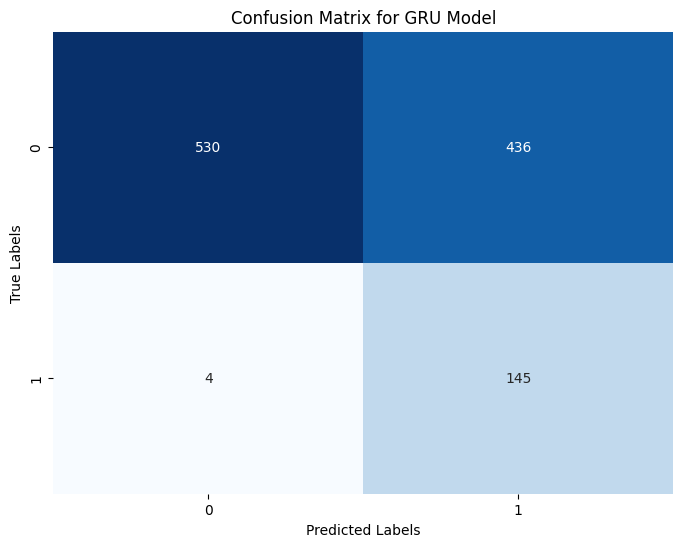

In [ ]:
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


#Too much exhaustive

# Conversion des matrices creuses en tableaux denses et redimensionnement pour le GRU
X_train_gru = X_train_tfidf.toarray().reshape((X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1))
X_test_gru = X_test_tfidf.toarray().reshape((X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1))

# Calcul des poids de classe pour gérer le déséquilibre des classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Définition d'un modèle GRU amélioré
model_gru = Sequential([
    GRU(units=64, return_sequences=True, input_shape=(X_train_gru.shape[1], 1)),
    Dropout(0.5),
    GRU(units=32),
    Dropout(0.5),
    BatchNormalization(),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=1, activation='sigmoid')
])

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_gru = model_gru.fit(X_train_gru, y_train, epochs=10, validation_split=0.2, class_weight=class_weight_dict)

test_loss_gru, test_accuracy_gru = model_gru.evaluate(X_test_gru, y_test)
print(f"Test Accuracy with GRU: {test_accuracy_gru}")

predictions_gru = (model_gru.predict(X_test_gru) > 0.5).astype(int).flatten()

print(classification_report(y_test, predictions_gru, target_names=['Class 0', 'Class 1']))

# Calcul et affichage de la matrice de confusion
conf_matrix_gru = confusion_matrix(y_test, predictions_gru)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gru, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for GRU Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


**CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

input_dim = X_train_dense.shape[1]

model_cnn_tfidf = Sequential()
model_cnn_tfidf.add(Dense(512, input_dim=input_dim, activation='relu'))
model_cnn_tfidf.add(Dropout(0.5))
model_cnn_tfidf.add(Dense(512, activation='relu'))
model_cnn_tfidf.add(Dropout(0.5))
model_cnn_tfidf.add(Dense(1, activation='sigmoid'))

model_cnn_tfidf.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

history_cnn_tfidf = model_cnn_tfidf.fit(X_train_final, y_train_final, epochs=5, batch_size=64, validation_data=(X_val_final, y_val_final), verbose=2)

loss, accuracy = model_cnn_tfidf.evaluate(X_test_dense, y_test, verbose=0)
print("Test Accuracy: {:.4f}".format(accuracy))

predictions = model_cnn_tfidf.predict(X_test_dense)
predictions = (predictions > 0.5).astype(int)

print(classification_report(y_test, predictions))

conf_mat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualisation de la courbe d'erreur
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_tfidf.history['loss'], label='Training Loss')
plt.plot(history_cnn_tfidf.history['val_loss'], label='Validation Loss')
plt.title('Courbe de Perte')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'X_train_dense' is not defined

Epoch 1/5
56/56 - 6s - loss: 0.2954 - accuracy: 0.8617 - val_loss: 0.1717 - val_accuracy: 0.8576 - 6s/epoch - 100ms/step
Epoch 2/5
56/56 - 3s - loss: 0.1122 - accuracy: 0.9475 - val_loss: 0.1130 - val_accuracy: 0.9821 - 3s/epoch - 53ms/step
Epoch 3/5
56/56 - 3s - loss: 0.0408 - accuracy: 0.9921 - val_loss: 0.0747 - val_accuracy: 0.9821 - 3s/epoch - 55ms/step
Epoch 4/5
56/56 - 3s - loss: 0.0112 - accuracy: 0.9975 - val_loss: 0.0838 - val_accuracy: 0.9832 - 3s/epoch - 60ms/step
Epoch 5/5
56/56 - 4s - loss: 0.0038 - accuracy: 0.9994 - val_loss: 0.0997 - val_accuracy: 0.9843 - 4s/epoch - 74ms/step
Test Accuracy: 0.9839
35/35 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.95      0.93      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      11

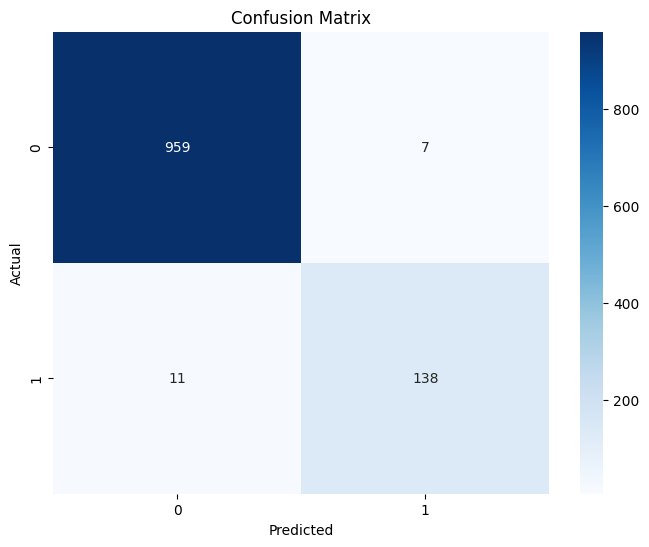

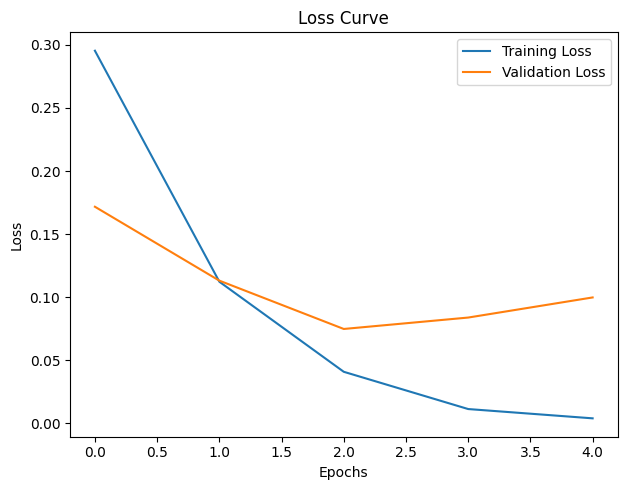

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


input_dim = X_train_tfidf.shape[1]

model_cnn_tfidf = Sequential()
model_cnn_tfidf.add(Dense(512, input_dim=input_dim, activation='relu'))
model_cnn_tfidf.add(Dropout(0.5))
model_cnn_tfidf.add(Dense(512, activation='relu'))
model_cnn_tfidf.add(Dropout(0.5))
model_cnn_tfidf.add(Flatten())
model_cnn_tfidf.add(Dense(1, activation='sigmoid'))

model_cnn_tfidf.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

history_cnn_tfidf = model_cnn_tfidf.fit(X_train_tfidf.toarray(), y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=2)

test_loss, test_accuracy = model_cnn_tfidf.evaluate(X_test_tfidf.toarray(), y_test, verbose=0)
print("Test Accuracy: {:.4f}".format(test_accuracy))

predictions = model_cnn_tfidf.predict(X_test_tfidf.toarray())
predictions = (predictions > 0.5).astype(int)

# Classification report and confusion matrix
print(classification_report(y_test, predictions))

conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualizing the error curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_tfidf.history['loss'], label='Training Loss')
plt.plot(history_cnn_tfidf.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
